In [1]:
%load_ext watermark
%load_ext snakeviz

In [2]:
%watermark -v -m

Python implementation: CPython
Python version       : 3.7.4
IPython version      : 7.16.1

Compiler    : Clang 4.0.1 (tags/RELEASE_401/final)
OS          : Darwin
Release     : 17.7.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit



In [3]:
from IPython.core.display import display, HTML
from pyinstrument import Profiler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import objgraph
import ray
import statistics
import time
import tracemalloc

In [4]:
ray.init(ignore_reinit_error=True)
print(f"Dashboard URL: http://{ray.get_dashboard_url()}")

File descriptor limit 256 is too low for production servers and may result in connection errors. At least 8192 is recommended. --- Fix with 'ulimit -n 8192'
2021-03-28 09:58:33,781	INFO services.py:1174 -- View the Ray dashboard at http://127.0.0.1:8265


Dashboard URL: http://127.0.0.1:8265


In [5]:
def estimate_pi (num_samples):
    xs = np.random.uniform(low=-1.0, high=1.0, size=num_samples)   # generate num_samples random samples for the x coordinate
    ys = np.random.uniform(low=-1.0, high=1.0, size=num_samples)   # generate num_samples random samples for the y coordinate
    xys = np.stack((xs, ys), axis=-1)                              # similar to Python's "zip(a,b)"; creates np.array([(x1,y1), (x2,y2), ...]).

    inside = (xs**2.0 + ys**2.0) <= 1.0                            # create a predicate over all the array elements
    xys_inside = xys[inside]                                       # select only those  elements inside the circle
    in_circle = xys_inside.shape[0]                                # return the number of elements inside the circle
    approx_pi = 4.0 * in_circle / num_samples                      # the Pi estimate

    return approx_pi

In [6]:
@ray.remote
def ray_estimate_pi (num_samples):
    return estimate_pi(num_samples)

In [7]:
def measure_epoch (n, trials=20, distrib=False):
    start = time.time()
    
    if distrib:
        refs = [ray_estimate_pi.remote(n) for _ in range(trials)]
        pis = ray.get(refs)
    else:
        pis = [estimate_pi(n) for _ in range(trials)]

    duration = time.time() - start
    approx_pi = statistics.mean(pis)
    stdev = statistics.stdev(pis)
    error = 100.0 * abs(approx_pi - np.pi) / np.pi

    return n, duration, approx_pi, stdev, error

In [8]:
def run_sim (distrib=False, max_n=100000, step=50000):
    results = [
        measure_epoch(n, distrib=distrib)
        for n in range(10, max_n, step)
    ]
    
    columns = ["n", "duration", "approx_pi", "stdev", "error"]
    df = pd.DataFrame(results, columns=columns)

    plt.plot("n", "error", data=df, marker="", color="red", linewidth=0.5, linestyle="dashed")
    plt.plot("n", "stdev", data=df, marker="", color="blue", linewidth=2)
    plt.plot("n", "duration", data=df, marker="", color="green", linewidth=1, linestyle="dashed")

    plt.yscale("log")
    plt.legend()
    plt.show()
    
    return df

Profiling tools:

  * [prun](https://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-prun)
  * [SnakeViz](https://jiffyclub.github.io/snakeviz/)
  * [Pyinstrument](https://github.com/joerick/pyinstrument/)
  * [objgraph](https://mg.pov.lt/objgraph/)
  * [tracemalloc](https://docs.python.org/3/library/tracemalloc.html)

In [9]:
objgraph.show_growth(limit=3)

function    43018    +43018
dict        25777    +25777
tuple       20509    +20509


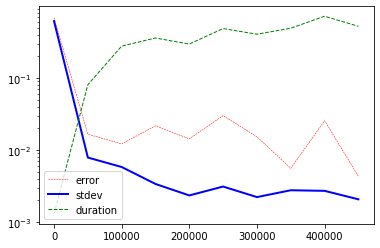

CPU times: user 3.4 s, sys: 452 ms, total: 3.85 s
Wall time: 4.72 s
 
*** Profile stats marshalled to file '/var/folders/zz/2ffrqd5j7n52x67qd94h_r_h0000gp/T/tmpghd5qnzf'. 
Embedding SnakeViz in this document...


 
*** Profile printout saved to text file 'prof_cpu.txt'. 


In [10]:
%%prun -q -T prof_cpu.txt
%%snakeviz
%%time

MAX_N = 500000 # 2000000

df1 = run_sim(distrib=False, max_n=MAX_N)
df1

In [11]:
objgraph.show_growth()

list                          10064      +658
dict                          26128      +351
weakref                        7635      +299
function                      43302      +284
cell                           8750      +256
tuple                         20744      +235
builtin_function_or_method     3798      +191
set                            1841      +191
Forward                          51       +49
And                             240       +35


In [12]:
objgraph.show_most_common_types() 

function                   43356
dict                       26137
tuple                      20798
list                       10064
cell                       9031
weakref                    7635
getset_descriptor          5828
type                       4664
method_descriptor          4023
builtin_function_or_method 3798


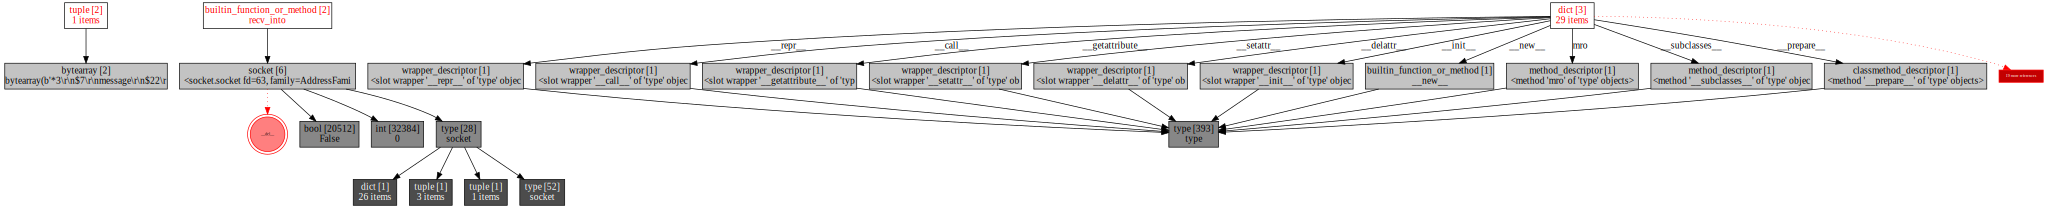

In [13]:
roots = objgraph.get_leaking_objects()
objgraph.show_refs(roots[:3], refcounts=True)

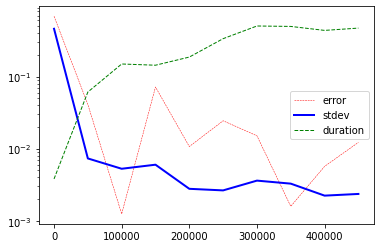

In [14]:
tracemalloc.start()

run_sim(distrib=False, max_n=MAX_N)

snapshot = tracemalloc.take_snapshot()

In [15]:
top_stats = snapshot.statistics('traceback')

# pick the biggest memory block
for stat in top_stats:
    print("%s memory blocks: %.1f KiB" % (stat.count, stat.size / 1024))

    for line in stat.traceback.format():
        print(line)

222 memory blocks: 478.7 KiB
  File "/opt/anaconda3/lib/python3.7/site-packages/matplotlib/lines.py", line 366
    self._color = None
373 memory blocks: 187.9 KiB
  File "/opt/anaconda3/lib/python3.7/site-packages/pyparsing.py", line 1844
    value = self._parseNoCache(instring, loc, doActions, callPreParse)
299 memory blocks: 161.8 KiB
  File "/opt/anaconda3/lib/python3.7/site-packages/matplotlib/artist.py", line 70
    self._stale = True
1048 memory blocks: 86.6 KiB
  File "/opt/anaconda3/lib/python3.7/site-packages/matplotlib/transforms.py", line 200
    self, lambda _, pop=child._parents.pop, k=id(self): pop(k))
1086 memory blocks: 79.1 KiB
  File "/opt/anaconda3/lib/python3.7/site-packages/matplotlib/transforms.py", line 116
    self._parents = {}
750 memory blocks: 70.3 KiB
  File "/opt/anaconda3/lib/python3.7/site-packages/pyparsing.py", line 1837
    lookup = (self, instring, loc, callPreParse, doActions)
149 memory blocks: 60.7 KiB
  File "/opt/anaconda3/lib/python3.7/site-pac

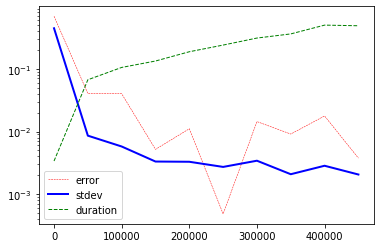


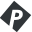

In [16]:
profiler = Profiler()
profiler.start()

run_sim(distrib=False, max_n=MAX_N)

profiler.stop()
display(HTML(profiler.output_html()))

In [17]:
df1.describe()

,n,duration,approx_pi,stdev,error
count,10.000000,10.000000,10.000000,10.000000,10.000000
mean,225010.000000,0.364084,3.139581,0.064907,0.083231
std,151382.517705,0.213332,0.006901,0.193978,0.212406
min,10.000000,0.001289,3.120000,0.002057,0.004293
25%,112510.000000,0.281893,3.141139,0.002421,0.012657
50%,225010.000000,0.382365,3.141747,0.002922,0.015867
75%,337510.000000,0.490163,3.142094,0.005180,0.024500
max,450010.000000,0.720876,3.142533,0.616953,0.687316


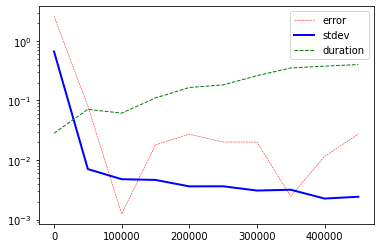

CPU times: user 883 ms, sys: 85.1 ms, total: 968 ms
Wall time: 2.78 s


,n,duration,approx_pi,stdev,error
count,10.000000,10.000000,10.000000,10.000000,10.000000
mean,225010.000000,0.201068,3.133592,0.069988,0.280602
std,151382.517705,0.138923,0.025877,0.209150,0.814265
min,10.000000,0.028301,3.060000,0.002258,0.001247
25%,112510.000000,0.080835,3.140978,0.003102,0.013163
50%,225010.000000,0.174123,3.141373,0.003623,0.020070
75%,337510.000000,0.329321,3.142075,0.004739,0.027310
max,450010.000000,0.401483,3.144135,0.665227,2.597175


In [18]:
%%time

df2 = run_sim(distrib=True, max_n=MAX_N)
df2.describe()

In [19]:
degree = 1
polyreg = make_pipeline(PolynomialFeatures(degree), LinearRegression())

X = df1.iloc[:, 0].values.reshape(-1, 1)
Y1 = df1.iloc[:, 1].values.reshape(-1, 1)
Y2 = df2.iloc[:, 1].values.reshape(-1, 1)

polyreg.fit(X, Y1)
Y1_pred = polyreg.predict(X)

polyreg.fit(X, Y2)
Y2_pred = polyreg.predict(X)

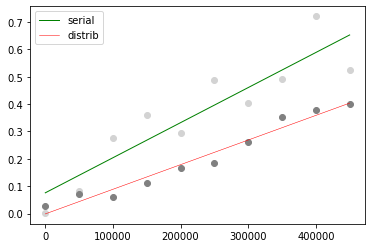

In [20]:
plt.scatter(X, Y1, color="lightgray")
plt.scatter(X, Y2, color="gray")

plt.plot(X, Y1_pred, color="green", linewidth=1, label="serial")
plt.plot(X, Y2_pred, color="red", linewidth=0.5, label="distrib")

plt.legend()
plt.show()

In [21]:
m = (Y1_pred / Y2_pred)
m

array([[-53.08852855],
       [  3.20731656],
       [  2.30149743],
       [  2.00600092],
       [  1.85943183],
       [  1.77186411],
       [  1.71364052],
       [  1.67212785],
       [  1.64103459],
       [  1.61687535]])

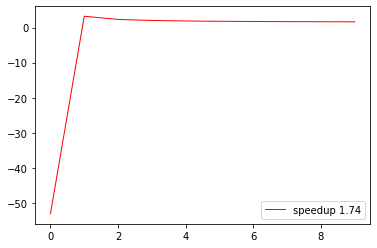

In [22]:
plt.plot(m, color="red", linewidth=1, label="speedup {:.2f}".format(np.median(m)))
plt.legend()
plt.show()